网点现金预测建模 Baseline
数据样本背景：佛山三水一住宅区附近网点，整体交易量在网点中属于中下水平
样本数据集：20180101-2020-05-31
验证数据集：20200602

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.api import tsa
import statsmodels.api as sm
import time
from matplotlib import font_manager as fm, rcParams
from chinese_calendar import is_workday, is_holiday
import calendar
plt.style.use('ggplot')
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置
%matplotlib inline

In [2]:
def sum_by_date(df):
    return df.groupby('date').sum()

def seq_filter_in(seq, threshold):
    return seq.loc[seq['txn_amt']<=threshold]

def seq_filter_out(seq, threshold):
    return seq.loc[seq['txn_amt']>=threshold]

def drop_trade_threshold(df,threshold):
    df = df.loc[df['txn_amt']<=threshold]
    return df

def get_daily_cash_req(tmp_df):
    tmp_df = tmp_df.sort_values(by=['date','prest_txn_tm'])
    tmp_group = tmp_df.groupby('date')
    tmp_group = tmp_group.cumsum()
    daily_cash_req = tmp_group.groupby('date').min()
    daily_cash_req = daily_cash_req.rename(columns={'txn_amt':'cash_req'})
    return daily_cash_req

def autocorrelation(timeseries, lags):
    import statsmodels.api as sm
    fig = plt.figure(figsize=(12, 8))
    plt.suptitle(timeseries.name, fontsize=20)
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()
    
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
#读取数据，数据
tmp_df = pd.read_csv('./iml_txn_dpst_fin_dtl_e_casestudy.csv')

tmp_df['date'] = pd.to_datetime(tmp_df['pass_acct_dt'], format='%Y%m%d')
tmp_df = tmp_df.loc[tmp_df['prest_txn_tm']!=0]
tmp_df = tmp_df.loc[tmp_df['txn_amt']>=-50000]
tmp_df.set_index('date', inplace=True)
tmp_df = tmp_df[['prest_txn_tm','txn_amt']]
tmp_df.head()

,prest_txn_tm,txn_amt
date,,
2019-07-13,10514868,150.0
2019-07-13,10320728,50.0
2019-07-13,11202778,50.0
2019-07-13,11202875,225.0
2019-07-13,15475186,80.0


In [4]:
tmp_df = seq_filter_in(tmp_df, 500000)
tmp_df = tmp_df.sort_values(by=['date','prest_txn_tm'])
tmp_group = tmp_df.groupby('date')
tmp_group = tmp_group.cumsum()
daily_cash_req = tmp_group.groupby('date').min()
daily_cash_req = daily_cash_req.rename(columns={'txn_amt':'cash_req'})
daily_cash_req.head(5)

,prest_txn_tm,cash_req
date,,
2018-01-01,3151059,-34188.0
2018-01-02,501102,-70600.0
2018-01-03,1392638,-1700.0
2018-01-04,554975,-36100.0
2018-01-05,1572877,1300.0


In [4]:
is_holi = []
for i in daily_cash_req.index:
    is_holi.append(is_holiday(i))
daily_cash_req['is_holi'] = is_holi
daily_cash_req

,prest_txn_tm,cash_req,is_holi
date,,,
2018-01-01,3151059,-34188.00,True
2018-01-02,501102,-70600.00,False
2018-01-03,1392638,-1700.00,False
2018-01-04,554975,-36100.00,False
2018-01-05,1572877,1300.00,False
...,...,...,...
2020-08-16,133665,-28680.73,True
2020-08-17,483137,-41971.77,False
2020-08-18,391095,-500.20,False


In [5]:
daily_cash_req.loc[daily_cash_req['is_holi']==True].describe()

,prest_txn_tm,cash_req
count,3.050000e+02,305.000000
mean,1.262173e+06,-60689.607869
std,1.687364e+06,56620.690340
min,8.990000e+02,-295255.000000
25%,2.309470e+05,-87101.000000
50%,4.049580e+05,-44400.000000
75%,1.563503e+06,-17400.000000
max,8.070056e+06,9800.000000


In [78]:
daily_cash_req.loc[~daily_cash_req['is_holi']==True].describe()

,prest_txn_tm,cash_req
count,6.580000e+02,658.000000
mean,1.048312e+06,-52871.132112
std,1.407311e+06,60673.921227
min,2.880000e+02,-426558.000000
25%,2.441732e+05,-75005.995000
50%,4.232125e+05,-36999.020000
75%,1.249858e+06,-12000.000000
max,9.405401e+06,195154.690000


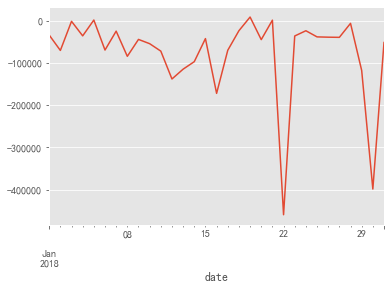

In [5]:
daily_cash_req['cash_req']['20180101':'20180131'].plot()

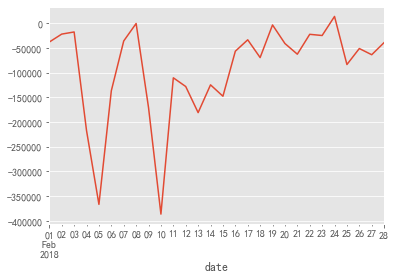

In [6]:
daily_cash_req['cash_req']['20180201':'20180228'].plot()

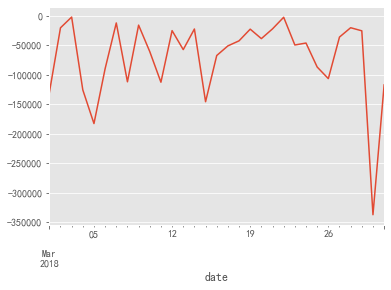

In [7]:
daily_cash_req['cash_req']['20180301':'20180331'].plot()

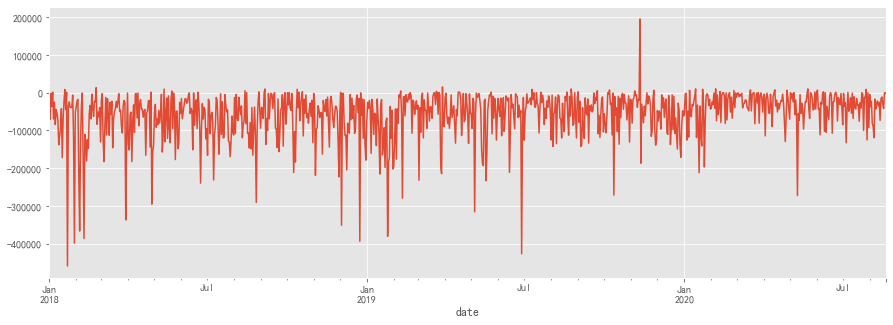

In [8]:
plt.style.use('ggplot')
fig = plt.subplots(figsize=(15,5))
daily_cash_req['cash_req'].plot()

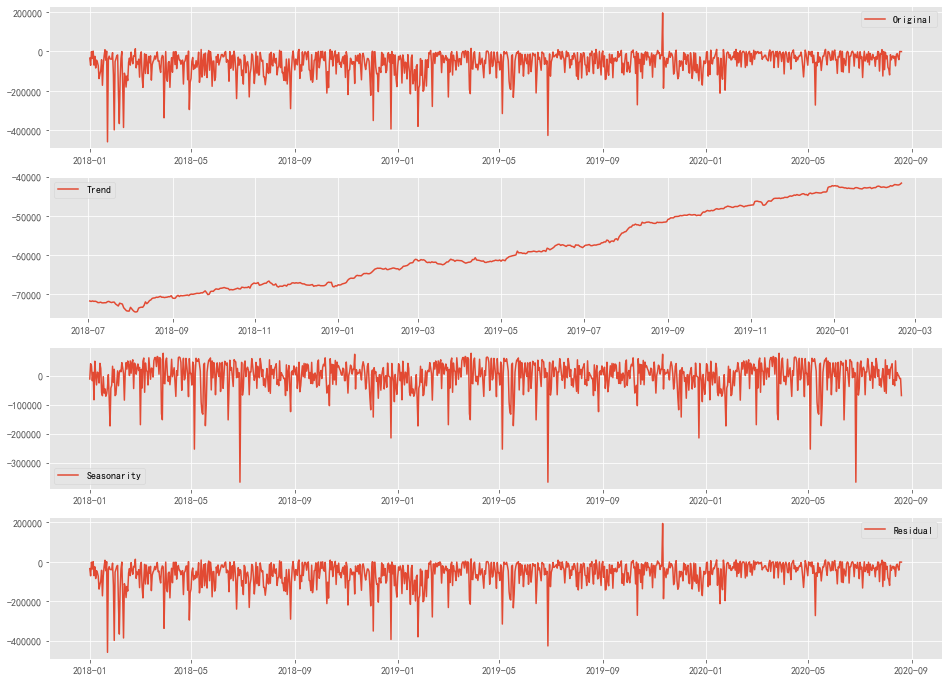

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decomposing(timeseries):
    decomposition = seasonal_decompose(timeseries, freq=365)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.figure(figsize=(16,12))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonarity')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(timeseries, label='Residual')
    plt.legend(loc='best')
    plt.show()
    
    return trend.fillna(0), seasonal.fillna(0), residual.fillna(0)

cash_req_t, cash_req_s, cash_req_r = decomposing(daily_cash_req['cash_req'])

In [10]:
train_seq_t = cash_req_t['20180101':'20200531']
val_seq_t = cash_req_t['20200601':'20200820']
train_seq_s = cash_req_s['20180101':'20200531']
val_seq_s = cash_req_s['20200601':'20200820']
train_seq_r = cash_req_r['20180101':'20200531']
val_seq_r = cash_req_r['20200601':'20200820']

In [12]:
res = sm.tsa.adfuller(daily_cash_req['cash_req'], regression='ct')
print('daily_cash_req:',res[1])

daily_cash_req: 1.365907539262369e-16


In [13]:
res = sm.tsa.adfuller(daily_cash_req['cash_req'].diff().fillna(0), regression='ct')
print('daily_cash_req_diff:',res[1])

daily_cash_req_diff: 1.4064338596680913e-17


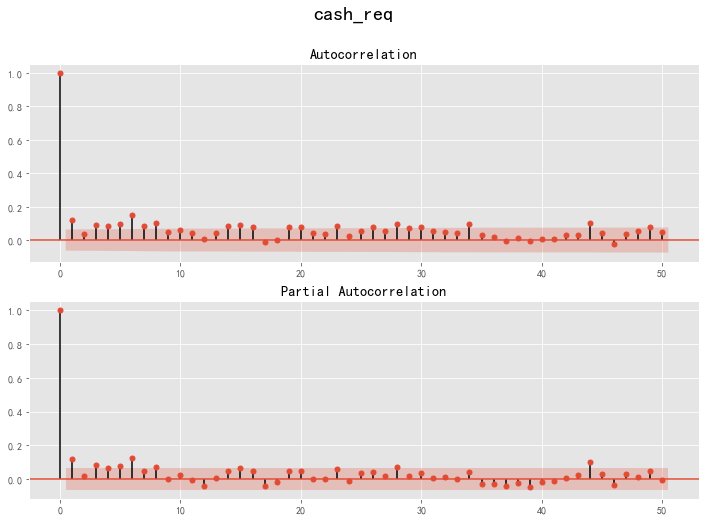

In [14]:
import statsmodels.api as sm

def autocorrelation(timeseries, lags):
    fig = plt.figure(figsize=(12, 8))
    plt.suptitle(timeseries.name, fontsize=20)
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()

autocorrelation(daily_cash_req['cash_req'], 50)


In [15]:
start = time.time()
order_evaluate = sm.tsa.arma_order_select_ic(daily_cash_req['cash_req'],ic='aic', trend='c', max_ar=7, max_ma=7)
print('ARMA(p,q) =',order_evaluate['aic_min_order'],'is the best.')
end = time.time()
print(end-start)

C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Us

ARMA(p,q) = (6, 6) is the best.
497.09309792518616


C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [19]:
arima = sm.tsa.statespace.SARIMAX(daily_cash_req['cash_req'][:'20200531'], order=(7,0,7), freq='D', seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False).fit()
arima.summary()

C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:               cash_req   No. Observations:                  882
Model:               SARIMAX(7, 0, 7)   Log Likelihood              -10900.042
Date:                Thu, 10 Sep 2020   AIC                          21830.084
Time:                        15:09:11   BIC                          21901.681
Sample:                    01-01-2018   HQIC                         21857.473
                         - 05-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3826      1.021      0.375      0.708      -1.618       2.383
ar.L2          0.3147      1.357      0.232      0.817      -2.344       2.974
ar.L3         -0.2801      0.671     -0.418      0.676      -1.594       1.034
ar.L4         -0.3227      0.880     -0.367      0.714      -2.047       1.401
ar.L5          0.4405      0.681      0.647      0.518      -0.894       1.775
ar.L6          0.2684      0.902      0.297      0.766      -1.500       2.037
ar.L7          0.1836      0.770      0.238      0.812      -1.326       1.693
ma.L1         -0.2761      1.018     -0.271      0.786      -2.271       1.719
ma.L2         -0.3000      1.273     -0.236      0.814      -2.795       2.195
ma.L3          0.2849      0.591      0.482      0.630      -0.873       1.442
ma.L4          0.3783      0.873      0.433      0.665      -1.334       2.090
ma.L5         -0.3864      0.660     -0.586      0.558      -1.680       0.907
ma.L6         -0.2163      0.892     -0.242      0.808      -1.965       1.532
ma.L7         -0.1885      0.733     -0.257      0.797      -1.626       1.249
sigma2      3.857e+09   8.34e-09   4.63e+17      0.000    3.86e+09    3.86e+09
===================================================================================
Ljung-Box (Q):                       37.16   Jarque-Bera (JB):              2351.11
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -1.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.15e+32. Standard errors may be unstable.
"""

ARIMA model RMSE:35984.06383863994
ARIMA model MAE:27034.083482348313


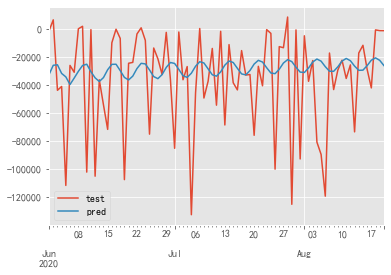

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred = arima.predict(start='20200531',end='20200820')[1:]
print('ARIMA model RMSE:{}'.format(np.sqrt(mean_squared_error(daily_cash_req['cash_req']['20200601':'20200820'],pred))))
print('ARIMA model MAE:{}'.format(mean_absolute_error(daily_cash_req['cash_req']['20200601':'20200820'],pred)))
pd.DataFrame({'test':daily_cash_req['cash_req']['20200601':'20200820'],'pred':pred}).plot()
plt.show()

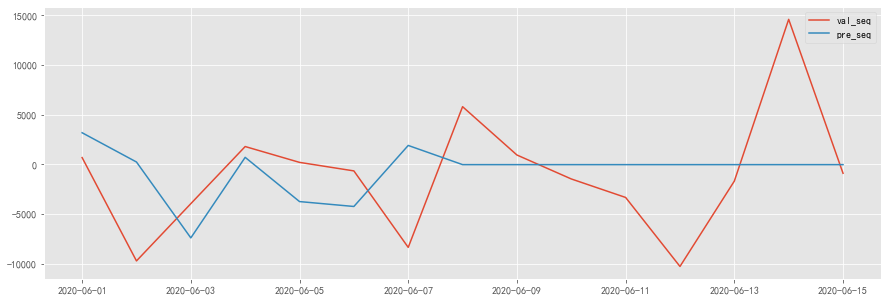

In [44]:
predict_seq = trend_model.predict(start='20200601',end='20200615', dynamic=True)
fig = plt.subplots(figsize=(15,5))
plt.plot(cash_req_t_diff['20200601':'20200615'], label='val_seq')
plt.plot(loc='best')
plt.plot(predict_seq, label='pre_seq')
plt.legend(loc='best')
plt.show()

In [45]:
def count_deposit_ratios(df, baseline):
    total = df.loc[df['txn_amt']>0].count()
    count = df.loc[df['txn_amt']>baseline].count()
    percentage = count/total
    print('total:{}, count:{}, percentage:{}'.format(total, count, percentage))
    return percentage
count_deposit_ratios(train_seq, 500000)


NameError: name 'train_seq' is not defined

In [37]:
import winsound
duration = 1000  # millisecond
freq = 600  # Hz
winsound.Beep(freq, duration)